In [1]:
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hydrotools.nwis_client.iv import IVDataService
import hydrotools.metrics.metrics as mt
%matplotlib widget

In [2]:
def retrieve_retro_data(
    feature_id: int,
    odir: Path = Path("NWM_data"),
    url: str = "s3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr/chrtout.zarr"
) -> pd.Series:
    """This function retrieves NWM retrospective data from AWS
    and returns a pandas.Series of streamflow data for a single
    channel feature.
    """
    # Check local file
    ofile = odir / f"NWM_{feature_id}.nc"
    if ofile.exists():
        return xr.open_dataarray(ofile).to_dataframe()["streamflow"]

    # Get xarray.dataset
    # Requires s3fs and zarr be installed
    ds = xr.open_dataset(
        url,
        backend_kwargs={
            "storage_options": {"anon": True},
            "consolidated": True
        },
        engine="zarr"
    )

    # Extract time series data
    da = ds.streamflow.sel(feature_id=feature_id)

    # Save
    odir.mkdir(exist_ok=True, parents=True)
    da.to_netcdf(ofile)

    # Return Series
    return da.to_dataframe()["streamflow"]

In [3]:
def retrieve_usgs_data(
    usgs_site_code: str,
    startDT: pd.Timestamp,
    endDT: pd.Timestamp,
    odir: Path = Path("USGS_data")
) -> pd.Series:
    """This function retrieves USGS streamflow data
    from the NWIS IV REST API.
    """
    # Check local file
    ofile = odir / f"USGS_{usgs_site_code}.nc"
    if ofile.exists():
        return pd.read_hdf(ofile)

    # Get data
    client = IVDataService()
    df = client.get(
        sites=usgs_site_code,
        startDT=startDT,
        endDT=endDT
    )

    # Save
    odir.mkdir(exist_ok=True, parents=True)
    df.to_hdf(ofile, key="data", format="table")

    # Return
    return df

In [4]:
# Load simulated data
simulated = retrieve_retro_data(9731488)

# Trim to whole water-years (Oct 1 - Sep 30)
# Convert to ft^3/s
start = pd.Timestamp("1979-10-01T00:00")
end = pd.Timestamp("2022-09-30T23:00")
simulated = simulated[start:end].div(0.3048 ** 3.0)

In [5]:
# Load observations
pairs = retrieve_usgs_data(
    usgs_site_code="02146470",
    startDT=start,
    endDT=end
)

# Process data
pairs = pairs[["value_time", "value"]].groupby(
    pd.Grouper(key="value_time", freq="1h")).first(
        min_count=1).rename(columns={"value": "observed"})

In [6]:
# Pair with simulations
pairs["simulated"] = simulated
pairs = pairs[pairs["observed"] > 0.0]
pairs = pairs.dropna()
pairs.head()

,observed,simulated
value_time,,
1986-10-02 05:00:00,0.02,6.003493
1986-10-02 06:00:00,0.02,6.003493
1986-10-02 07:00:00,0.02,6.003493
1986-10-02 08:00:00,0.02,6.003493
1986-10-02 09:00:00,0.02,6.003493


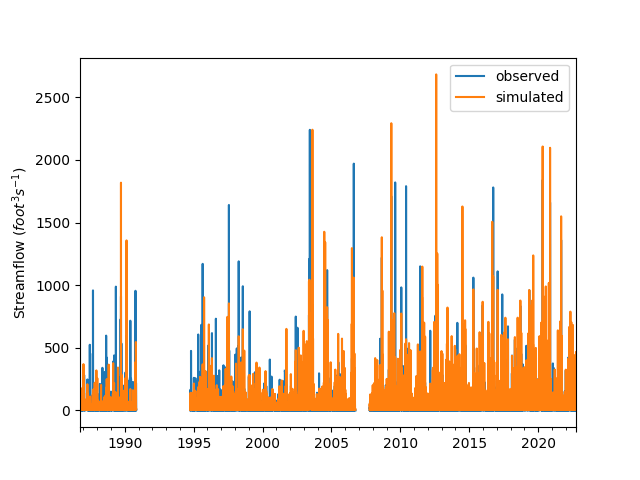

In [7]:
# Plot hydrograph
fig, ax = plt.subplots()
pairs.resample("1h").nearest(limit=1).plot(
    ax=ax,
    xlabel="",
    ylabel="Streamflow ($foot^3 s^{-1}$)"
)
plt.show(fig)

In [8]:
# Compute metrics
kge = mt.kling_gupta_efficiency(
    y_true=pairs["observed"],
    y_pred=pairs["simulated"]
)
bias = ((pairs["simulated"] - pairs["observed"]).sum() / pairs["observed"].sum()) * 100.0
cor = np.corrcoef(pairs["observed"], pairs["simulated"])[0][1]
obs_flash = pairs["observed"].diff().abs().sum() / pairs["observed"].sum()
sim_flash = pairs["simulated"].diff().abs().sum() / pairs["simulated"].sum()
flash_error = ((sim_flash - obs_flash) / obs_flash) * 100.0
pd.DataFrame(
    data=[[kge, "--"], [cor, "--"], [bias, "%"], [flash_error, "%"]],
    index=["KGE", "Correlation", "Bias", "Flashiness Error"],
    columns=["metrics", "units"]
)

,metrics,units
KGE,-1.006731,--
Correlation,0.651260,--
Bias,196.426722,%
Flashiness Error,-53.840335,%


In [9]:
# Compare quantiles
q = np.linspace(0.0, 1.0, 10001)
obs = pairs["observed"].quantile(q)
sim = pairs["simulated"].quantile(q)

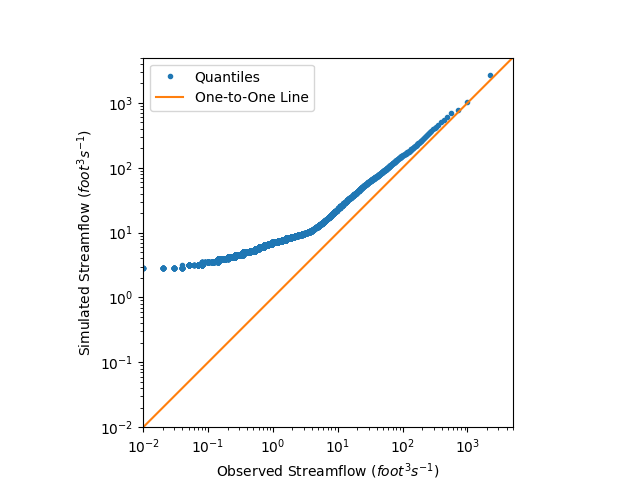

In [10]:
# Q-Q Plot
fig2, ax2 = plt.subplots()
ax2.loglog(obs, sim, ".", label="Quantiles")
ax2.plot([0.01, 5000.0], [0.01, 5000.0], "-", label="One-to-One Line")
ax2.set_xlim(0.01, 5000.0)
ax2.set_ylim(0.01, 5000.0)
ax2.set_aspect("equal")
ax2.set_xlabel("Observed Streamflow ($foot^3 s^{-1}$)")
ax2.set_ylabel("Simulated Streamflow ($foot^3 s^{-1}$)")
ax2.legend()
plt.show(fig2)